In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

In [2]:
!pip install xlrd 

In [3]:
# import data
df_fig5 = pd.read_excel('datasets/longprices.xls', sheet_name='all', header=2, index_col=0).iloc[1:]
df_fig5.index = df_fig5.index.astype(int) 

df_fig5.head(5)

,UK,US,France,Castile
1600,72.455009,NaN,NaN,48.559223
1601,84.609771,NaN,NaN,41.760932
1602,74.349258,NaN,NaN,40.158477
1603,70.718615,NaN,NaN,40.595510
1604,63.773036,NaN,NaN,44.480248


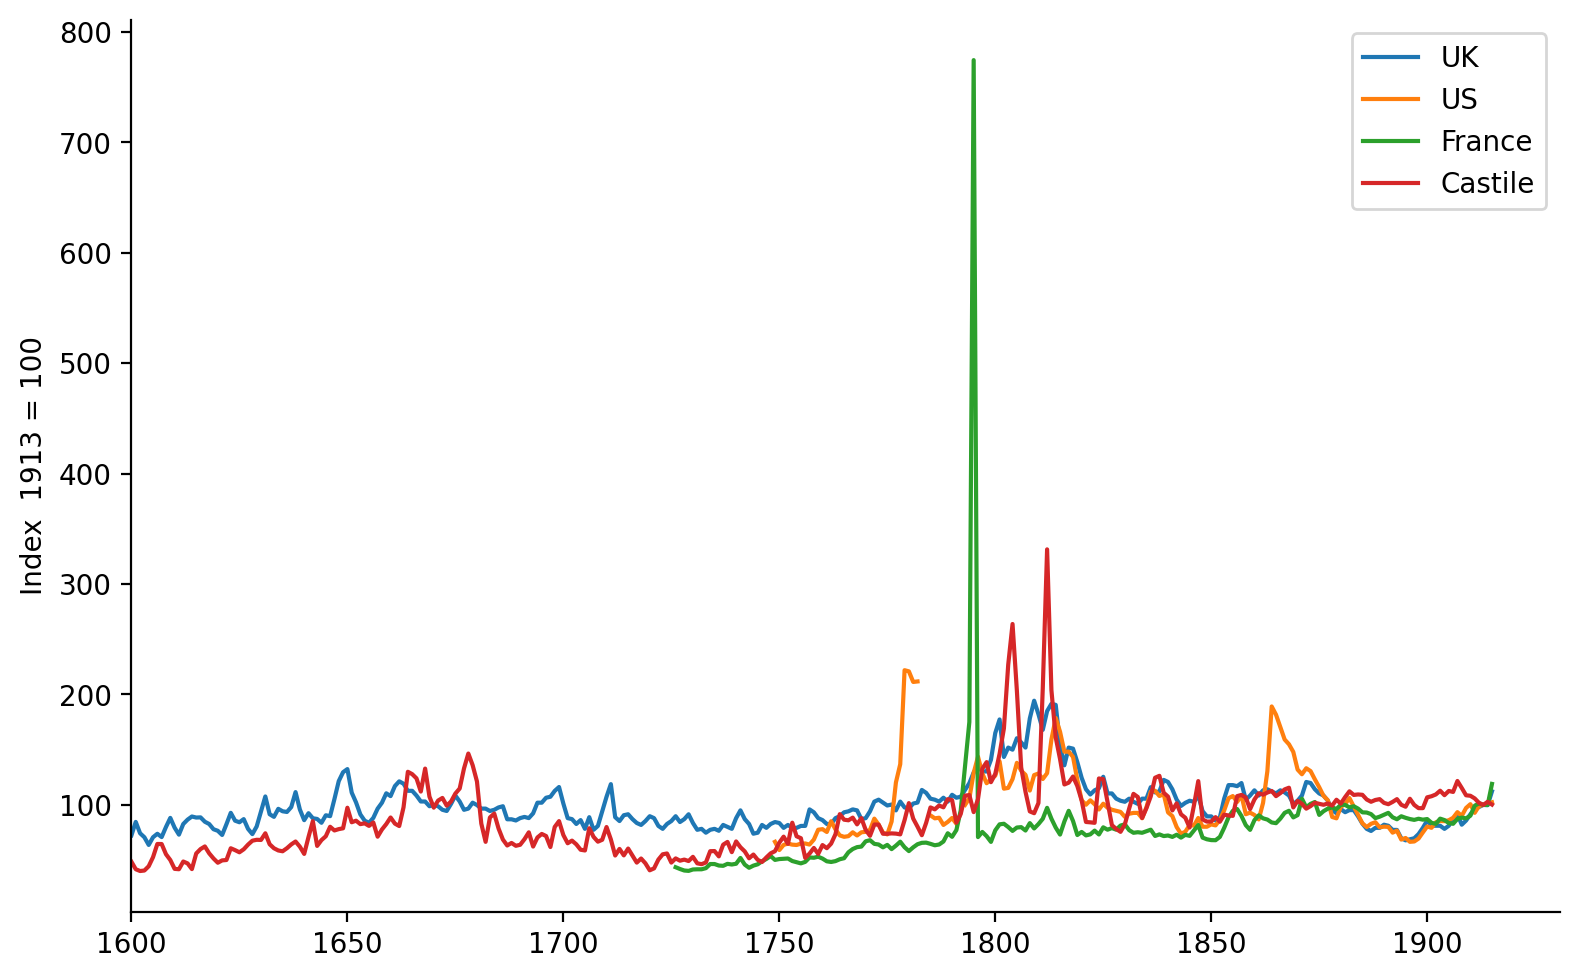

In [4]:
df_fig5_bef1914 = df_fig5[df_fig5.index <= 1915]

# create plot
cols = ['UK', 'US', 'France', 'Castile']

fig, ax = plt.subplots(1, 1, figsize=[8, 5], dpi=200)

for col in cols:
    ax.plot(df_fig5_bef1914.index, df_fig5_bef1914[col], label=col)

ax.spines[['right', 'top']].set_visible(False)
ax.legend()
ax.set_ylabel('Index  1913 = 100')
ax.set_xlim(xmin=1600)
plt.tight_layout()
plt.show()

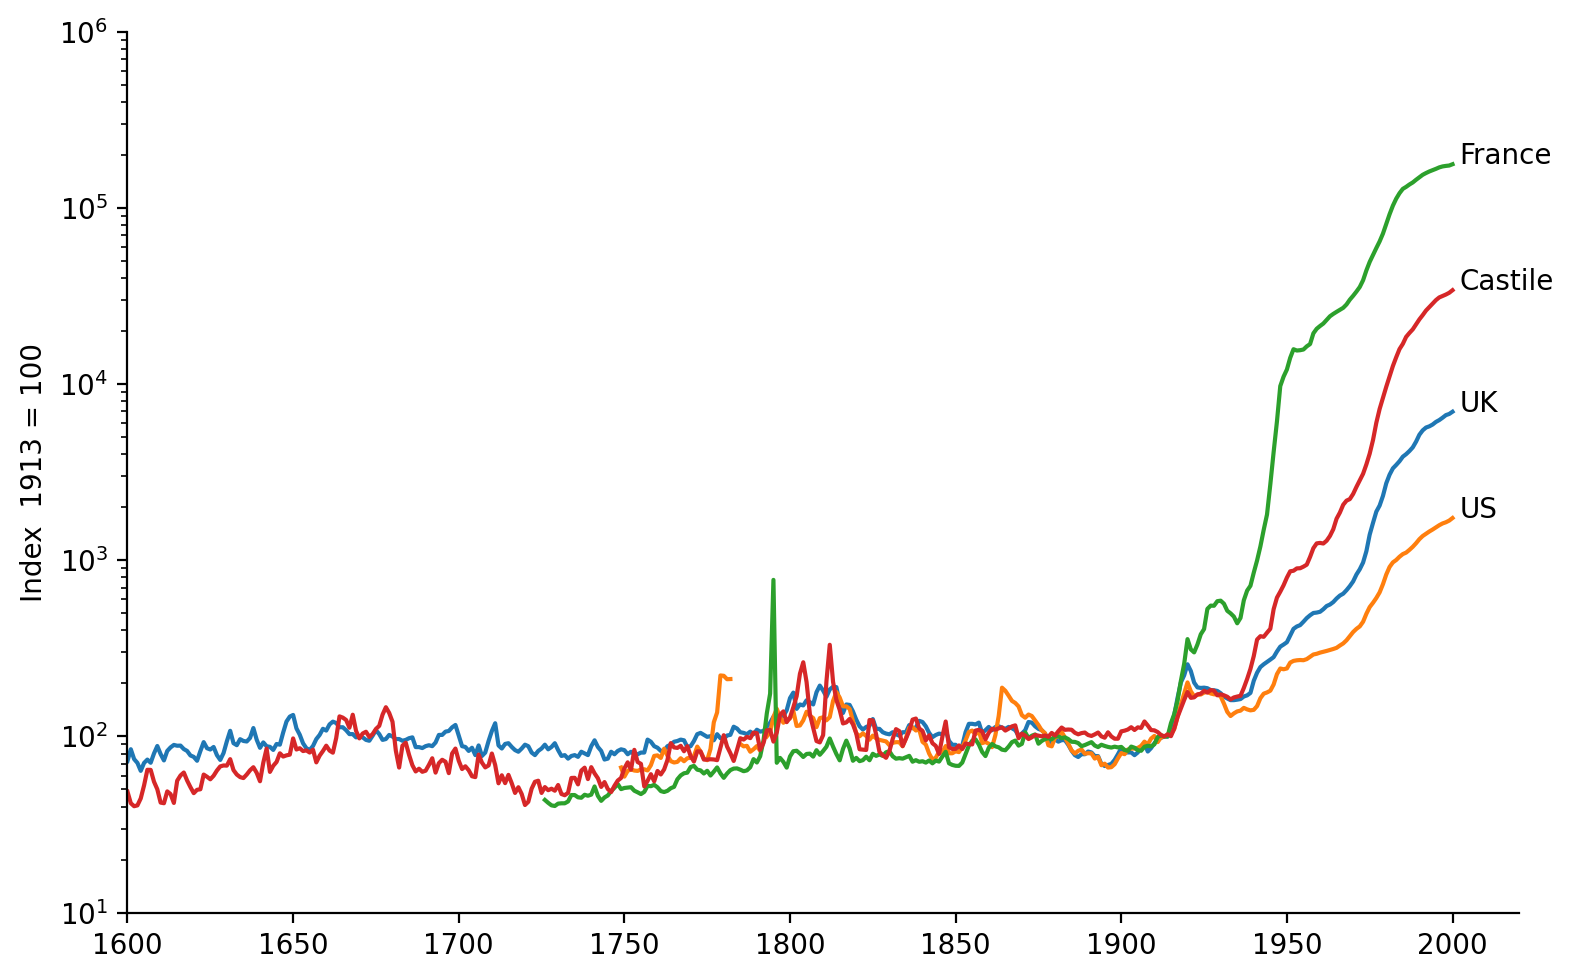

In [5]:
# create plot
cols = ['UK', 'US', 'France', 'Castile']

fig, ax = plt.subplots(1, 1, figsize=[8, 5], dpi=200)

for col in cols:
    ax.plot(df_fig5.index, df_fig5[col])
    ax.text(x=df_fig5.index[-1]+2, y=df_fig5[col].iloc[-1], s=col)

ax.spines[['right', 'top']].set_visible(False)
ax.set_yscale('log')
ax.set_ylabel('Index  1913 = 100')
ax.set_xlim(xmin=1600)
ax.set_ylim([10, 1e6])
plt.tight_layout()
plt.show()

In [6]:
def process_entry(entry):
    "Clean each entry of a dataframe."
    
    if type(entry) == str:
        # remove leading and trailing whitespace
        entry = entry.strip()
        # remove comma
        entry = entry.replace(',', '')
    
        # remove HTML markers
        item_to_remove = ['<s>a</s>', '<s>c</s>', '<s>d</s>', '<s>e</s>']

        # <s>b</s> represents a billion
        if '<s>b</s>' in entry:
            entry = entry.replace('<s>b</s>', '')
            entry = float(entry) * 1e9
        else:
            for item in item_to_remove:
                if item in entry:
                    entry = entry.replace(item, '')
    return entry

def process_df(df):
    "Clean and reorganize the entire dataframe."
    
    # remove HTML markers from column names
    for item in ['<s>a</s>', '<s>c</s>', '<s>d</s>', '<s>e</s>']:
        df.columns = df.columns.str.replace(item, '')
    
    df['Year'] = df['Year'].apply(lambda x: int(x))
    
    # set index to date time
    df = df.set_index(
            pd.to_datetime((df['Year'].astype(str) + df['Month'].astype(str)), format='%Y%B'))
    df = df.drop(['Year', 'Month'], axis=1)
    
    # handle duplicates by keeping the first
    df = df[~df.index.duplicated(keep='first')]
    
    # convert to numeric
    df = df.applymap(lambda x: float(x) if x != '—' else np.nan)
    
    # finally, we only focus on data between 1919 and 1925
    mask = (df.index >= '1919-01-01') & (df.index < '1925-01-01')
    df = df.loc[mask]

    return df

def create_plot(p_seq, e_seq, index, labs, ax):
    
    p_lab, e_lab = labs
    
    # price and exchange rates
    ax.plot(index, p_seq, label=p_lab, color='tab:blue')
    ax1 = ax.twinx()
    ax1.plot([None], [None], label=p_lab, color='tab:blue')
    ax1.plot(index, e_seq, label=e_lab, color='tab:orange')
    ax.set_yscale('log')
    ax1.set_yscale('log')
    
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    
    ax.text(-0.08, 1.03, 'Price Level', transform=ax.transAxes)
    ax.text(0.92, 1.03, 'Exchange Rate', transform=ax.transAxes)
    
    ax1.legend(loc='upper left')

    return ax1

In [7]:
# import data
xls = pd.ExcelFile('datasets/chapter_3.xlsx')

# unpack and combine all series
sheet_index = [(2, 3, 4), (9, 10), (14, 15, 16), (21, 18, 19)]
remove_row = [(-2, -2, -2), (-7, -10), (-6, -4, -3), (-19, -3, -6)]

df_list = []

for i in range(4):
    
    indices, rows = sheet_index[i], remove_row[i]
    sheet_list = [pd.read_excel(xls, 'Table3.' + str(ind), header=1).iloc[:row].applymap(process_entry)
                  for ind, row in zip(indices, rows)]
    
    sheet_list = [process_df(df) for df in sheet_list]
    df_list.append(pd.concat(sheet_list, axis=1))

df_Aus, df_Hung, df_Pol, df_Germ = df_list

In [8]:
df_Aus.head(5)

,Total Note Circulation,"Retail price index, 52 commodities",Exchange Rate
1919-01-01,NaN,NaN,17.09
1919-02-01,NaN,NaN,20.72
1919-03-01,4687056.0,NaN,25.85
1919-04-01,5577851.0,NaN,26.03
1919-05-01,5960003.0,NaN,24.75


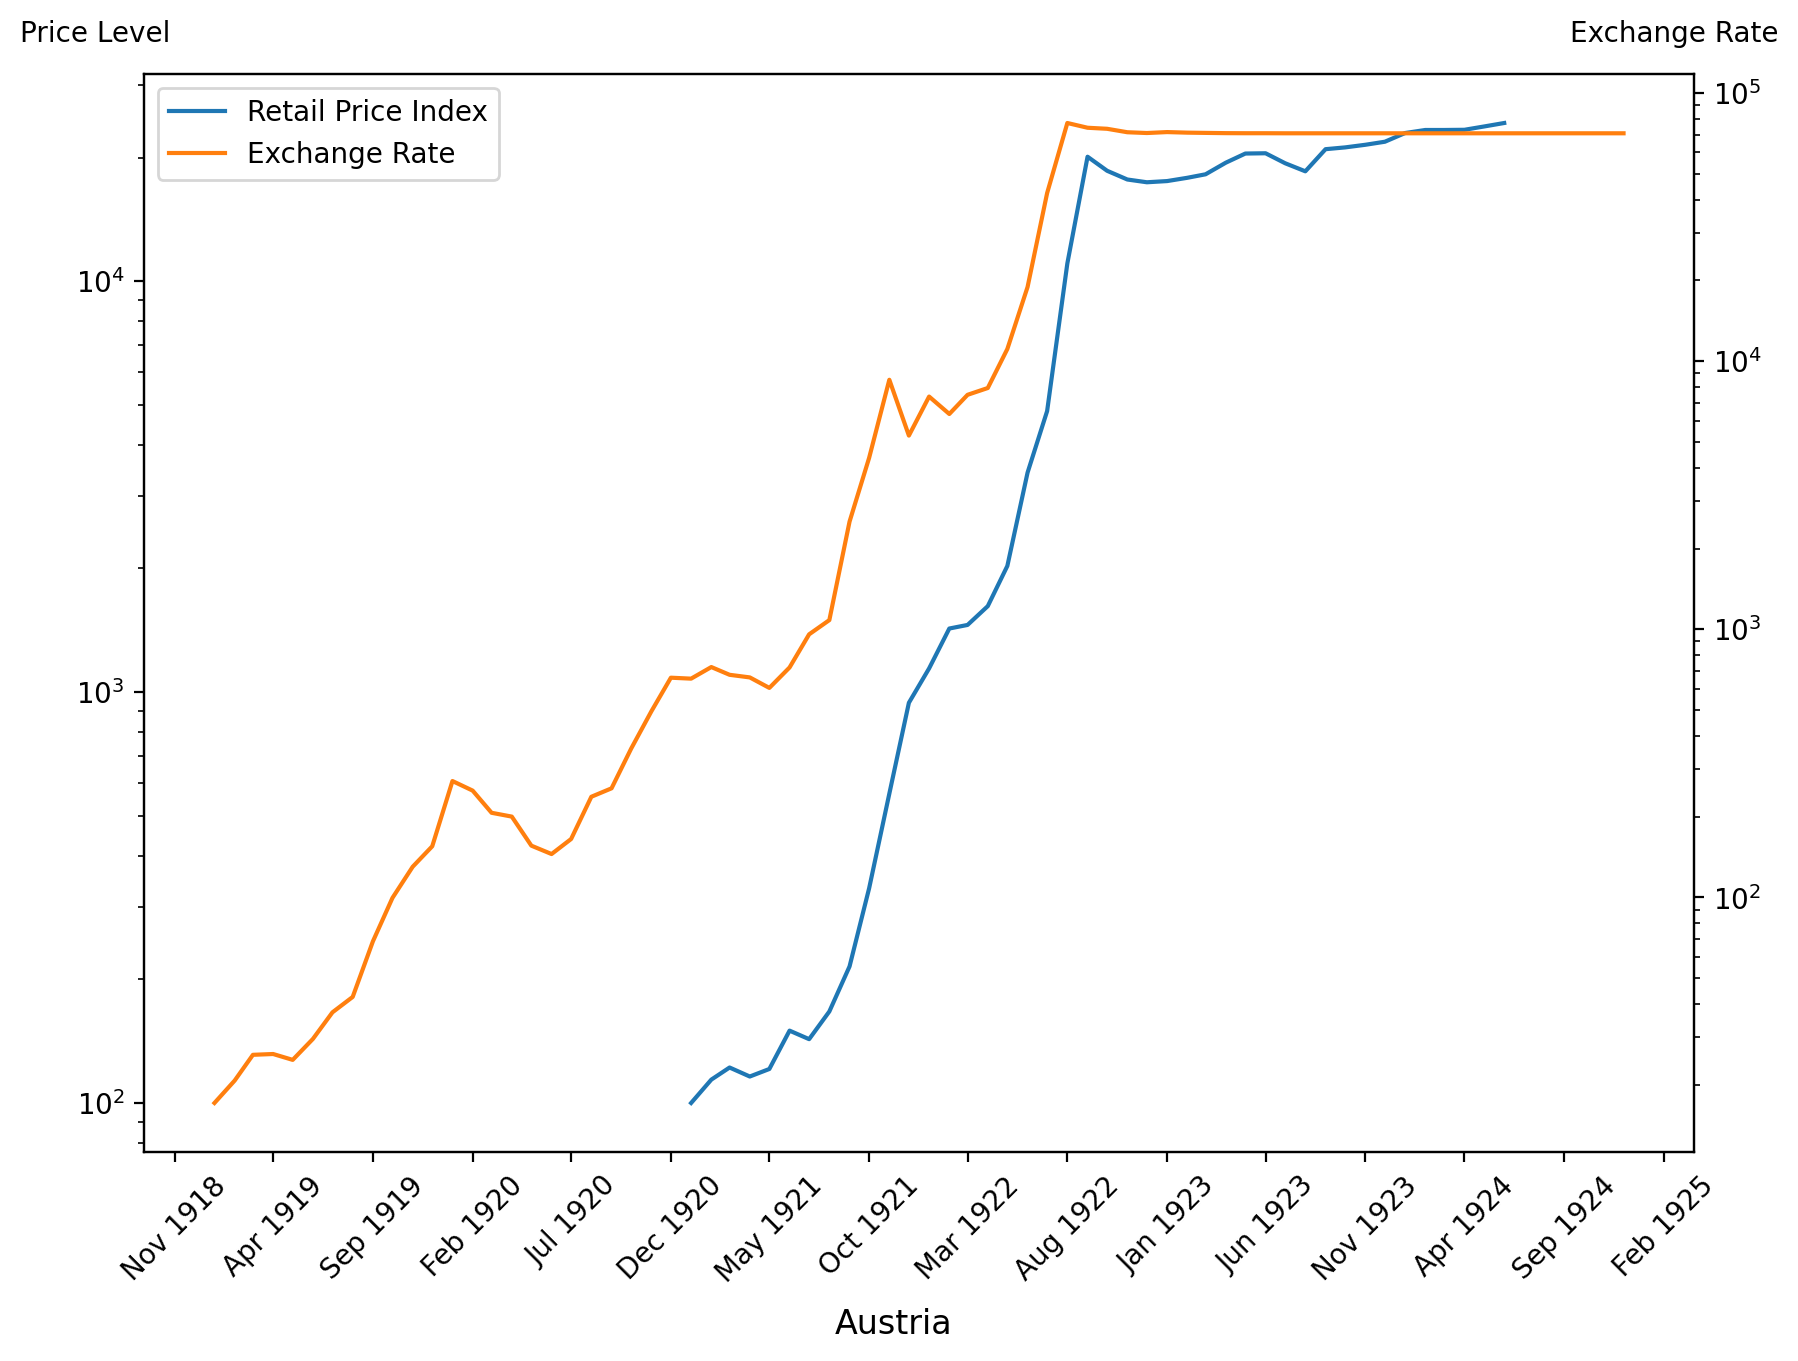

In [9]:
p_seq = df_Aus['Retail price index, 52 commodities']
e_seq = df_Aus['Exchange Rate']

lab = ['Retail Price Index', 'Exchange Rate']

# create plot
fig, ax = plt.subplots(figsize=[10,7], dpi=200)
_ = create_plot(p_seq, e_seq, df_Aus.index, lab, ax)

# connect disjunct parts
plt.figtext(0.5, -0.02, 'Austria', horizontalalignment='center', fontsize=12)
plt.show()

In [10]:
df_Hung.head(5)

,Gold coin and bullion,Silver coin,Foreign currency and exchange,Bills discounted,Advances on securities,Advances to treasury,Notes in circulation,Currrent accounts and deposits,Hungarian index of prices,Cents per crown in New York
1921-01-01,NaN,NaN,NaN,10924.0,195.0,NaN,15206.0,3851.0,NaN,NaN
1921-02-01,NaN,NaN,NaN,13202.0,162.0,NaN,15571.0,5531.0,NaN,NaN
1921-03-01,NaN,NaN,NaN,12862.0,160.0,NaN,15650.0,5246.0,NaN,NaN
1921-04-01,NaN,NaN,NaN,12178.0,110.0,NaN,13114.0,6802.0,NaN,NaN
1921-05-01,NaN,NaN,NaN,11847.0,111.0,NaN,13686.0,5760.0,NaN,NaN


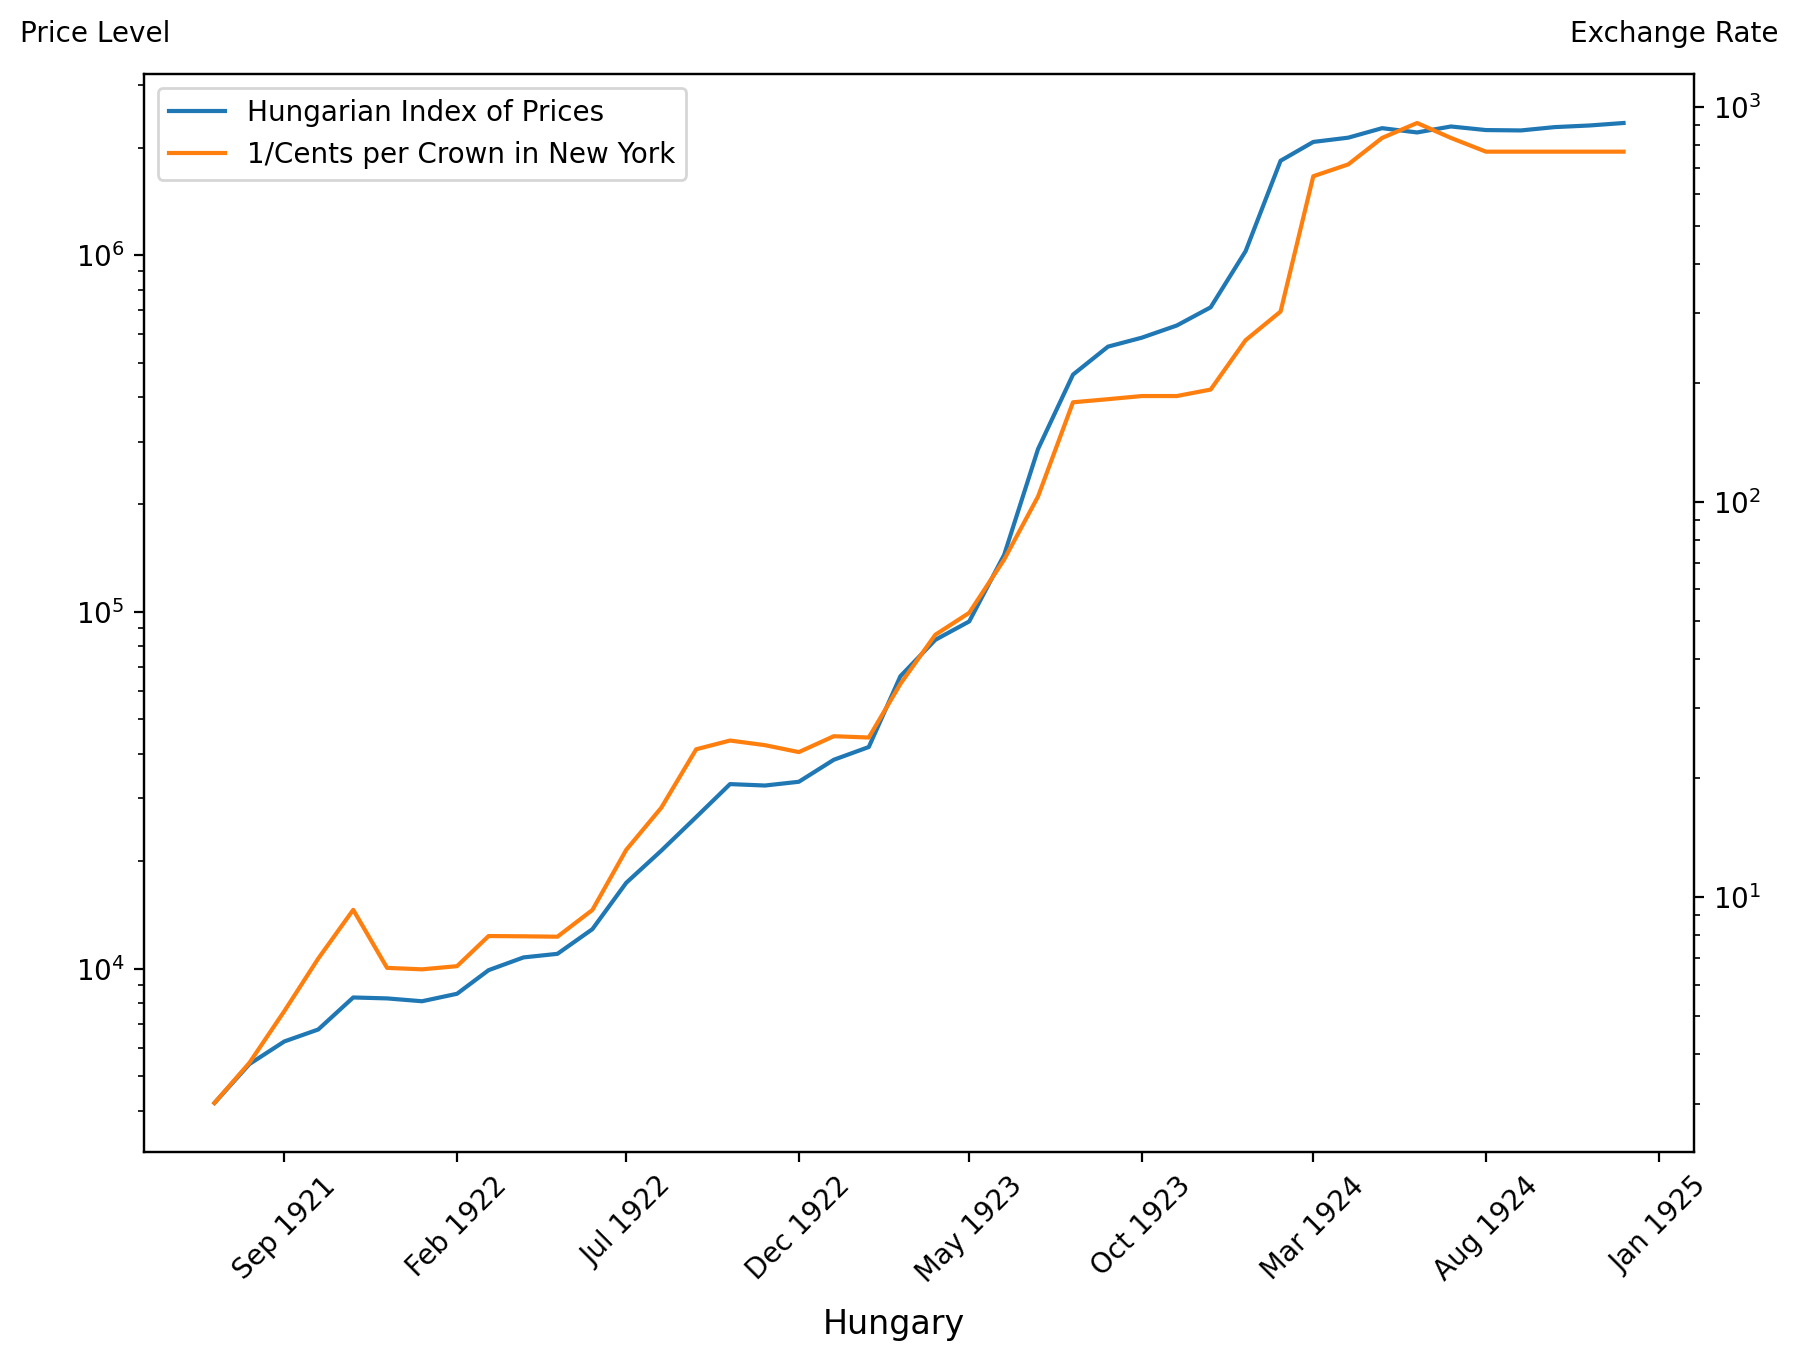

In [11]:
m_seq = df_Hung['Notes in circulation']
p_seq = df_Hung['Hungarian index of prices']
e_seq = 1/df_Hung['Cents per crown in New York']
rb_seq = np.log(m_seq) - np.log(p_seq)

lab = ['Hungarian Index of Prices', '1/Cents per Crown in New York']

# create plot
fig, ax = plt.subplots(figsize=[10,7], dpi=200)
_ = create_plot(p_seq, e_seq, df_Hung.index, lab, ax)

plt.figtext(0.5, -0.02, 'Hungary', horizontalalignment='center', fontsize=12)
plt.show()

In [12]:
df_Pol.head(5)

,Gold,Silver (including base coin),Balances with foreign banks,Discounts,Advances: Commercial,Advances: Government,Note circulation,Gold and Silver (together),Wholesale price index,Wholesale Price Index: On paper currency basis,Wholesale Price Index: On zloty basis,Cents per Polish mark (zloty after May 1924)
1919-01-01,NaN,NaN,NaN,5.0,194.7,209.9,1098.1,NaN,NaN,NaN,NaN,NaN
1919-02-01,NaN,NaN,NaN,4.2,196.4,315.0,1160.0,NaN,NaN,NaN,NaN,NaN
1919-03-01,3.7,4.2,3.9,3.5,189.7,400.0,1223.2,NaN,NaN,NaN,NaN,NaN
1919-04-01,3.7,4.4,9.4,2.5,192.8,575.0,1346.0,NaN,NaN,NaN,NaN,NaN
1919-05-01,3.7,8.9,5.8,1.8,193.2,925.0,1548.3,NaN,NaN,NaN,NaN,NaN


In [13]:
# splice three price series in different units
p_seq1 = df_Pol['Wholesale price index'].copy()
p_seq2 = df_Pol['Wholesale Price Index: On paper currency basis'].copy()
p_seq3 = df_Pol['Wholesale Price Index: On zloty basis'].copy()

# non-nan part
ch_index_1 = p_seq1[~p_seq1.isna()].index[-1]
ch_index_2 = p_seq2[~p_seq2.isna()].index[-2]

adj_ratio12 = p_seq1[ch_index_1]/p_seq2[ch_index_1]
adj_ratio23 = p_seq2[ch_index_2]/p_seq3[ch_index_2]

# glue three series
p_seq = pd.concat([p_seq1[:ch_index_1], 
                   adj_ratio12 * p_seq2[ch_index_1:ch_index_2], 
                   adj_ratio23 * p_seq3[ch_index_2:]])
p_seq = p_seq[~p_seq.index.duplicated(keep='first')]

# exchange rate
e_seq = 1/df_Pol['Cents per Polish mark (zloty after May 1924)']
e_seq[e_seq.index > '05-01-1924'] = np.nan

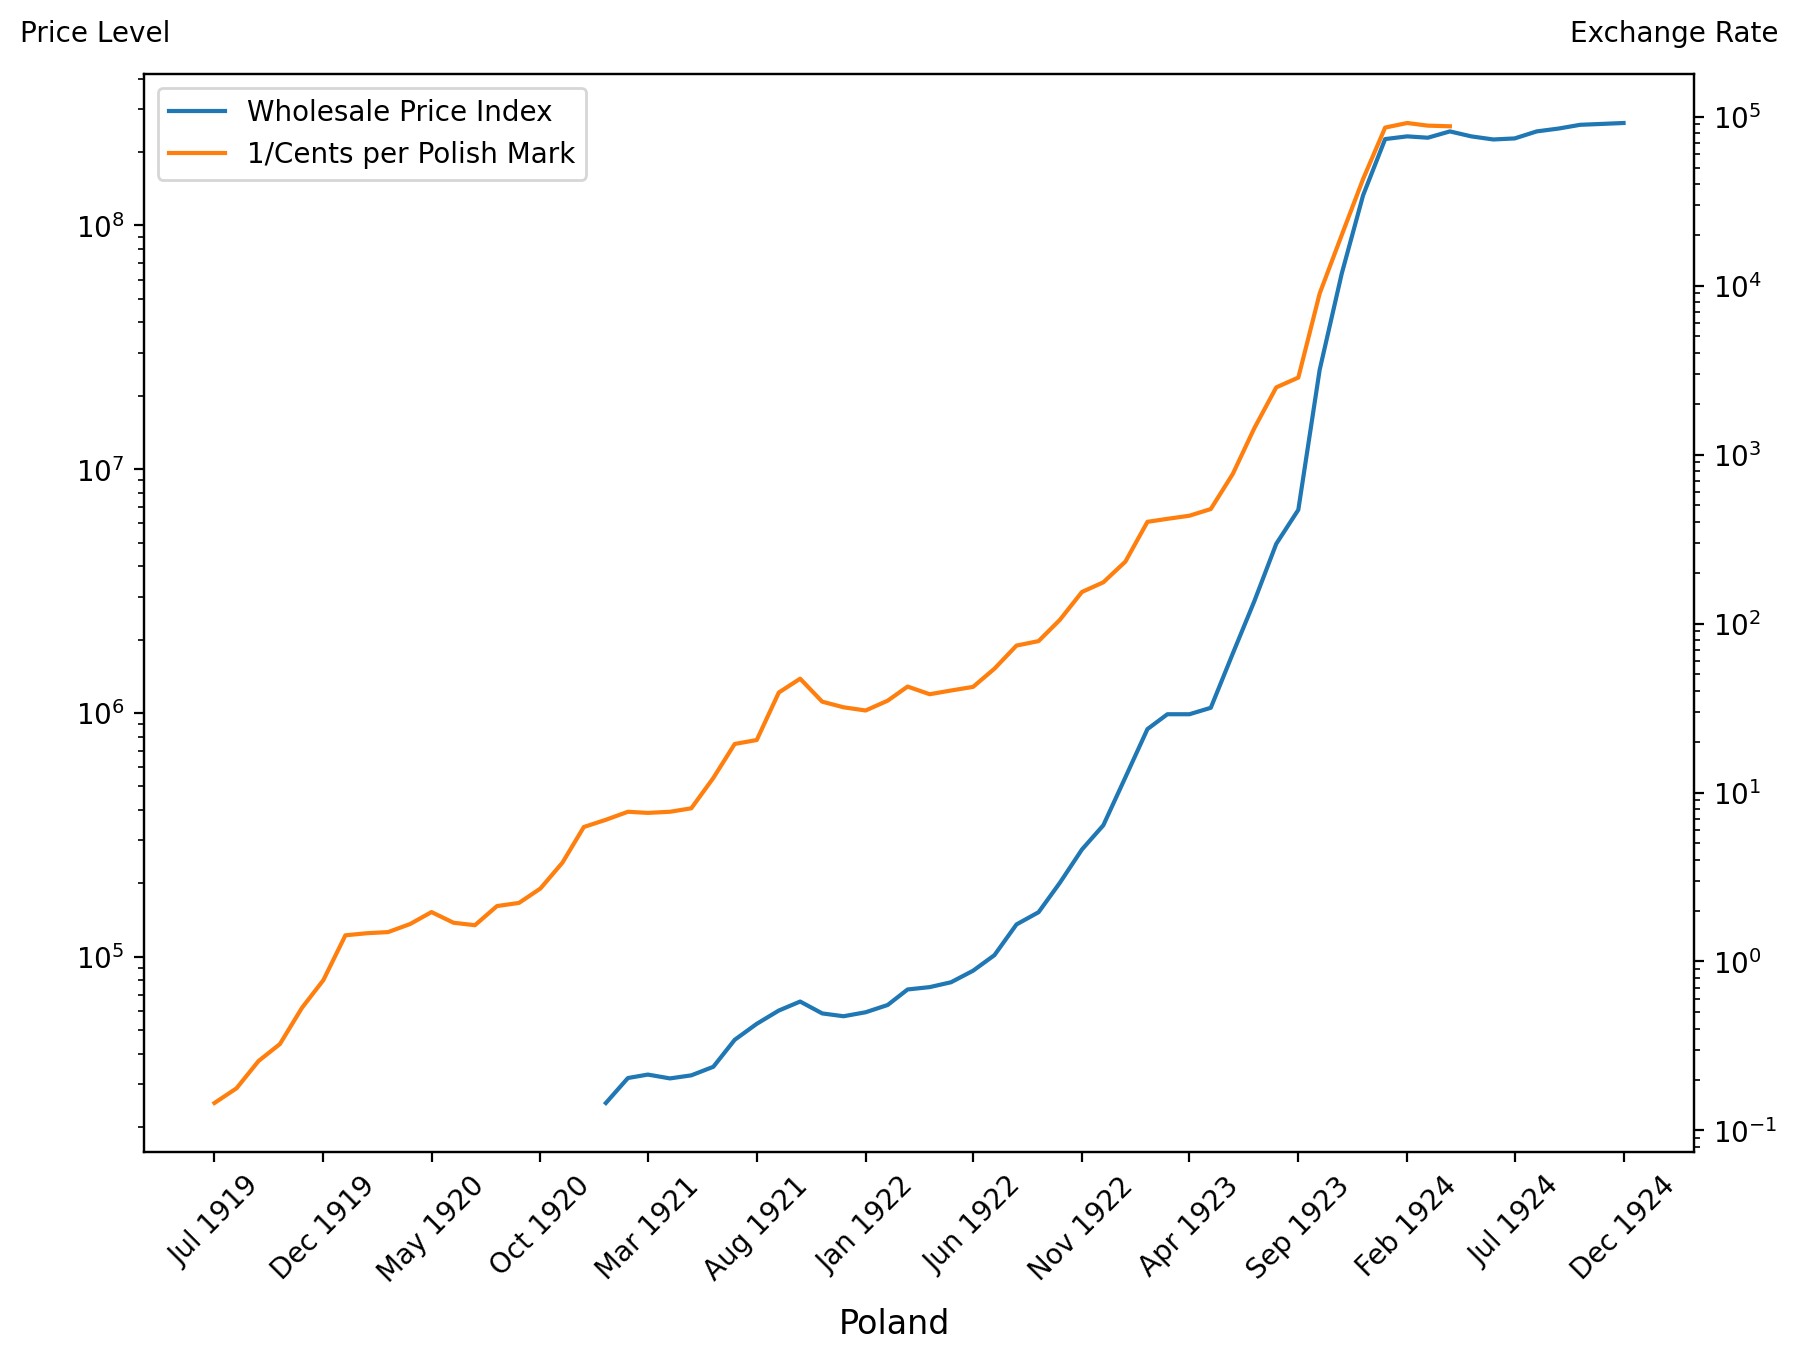

In [14]:
lab = ['Wholesale Price Index', '1/Cents per Polish Mark']

# create plot
fig, ax = plt.subplots(figsize=[10,7], dpi=200)
ax1 = create_plot(p_seq, e_seq, df_Pol.index, lab, ax)

plt.figtext(0.5, -0.02, 'Poland', horizontalalignment='center', fontsize=12)
plt.show()

In [15]:
df_Germ.head(5)

,Day,Gold Held Abroad,Gold In vault,Gold Total,Other metallic currency,Total coin and bullion,Foreign exchange,Treasury and loan bank notes,Notes of other banks,Rentenbank notes,...,Total discounted treasury and commercial bills,Advances,Securities,Notes in circulation,Public Demand deposits,Other Demand deposits,Total demand deposits,Demand deposits due to the Rentenbank,"Price index (on basis of marks before July 1924, reichsmarks after)",Cents per mark
1919-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262.0,NaN
1919-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270.0,NaN
1919-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.0,NaN
1919-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,286.0,NaN
1919-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,297.0,NaN


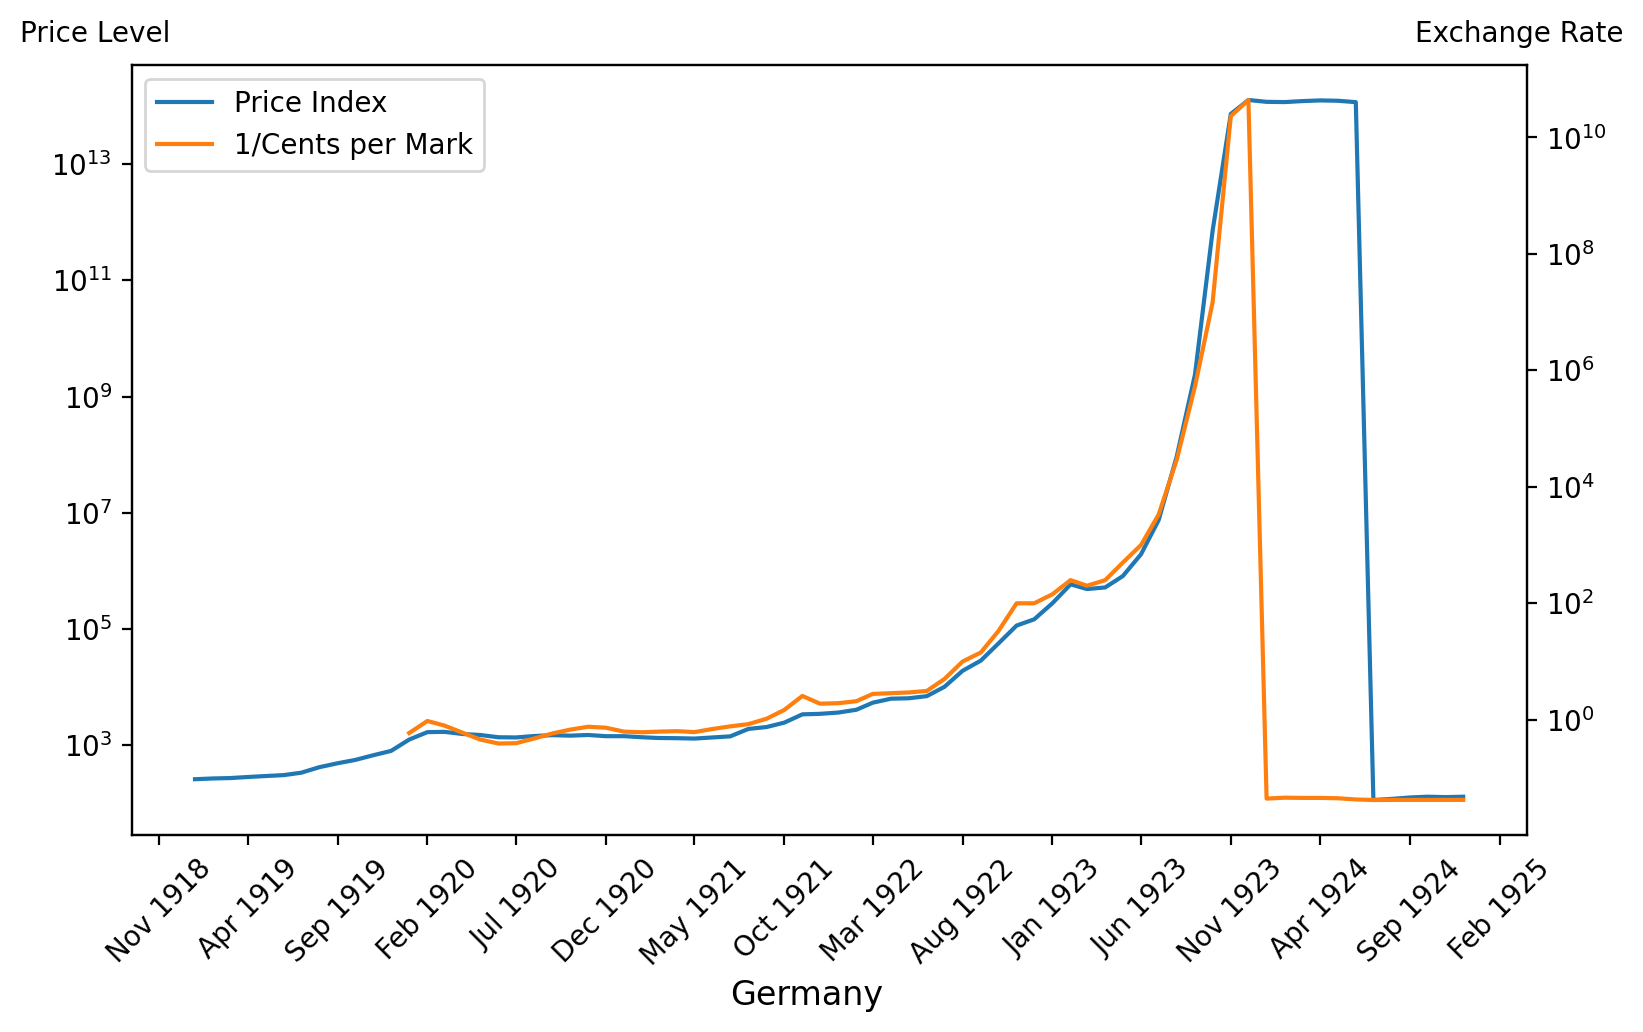

In [16]:
p_seq = df_Germ['Price index (on basis of marks before July 1924,  reichsmarks after)'].copy()
e_seq = 1/df_Germ['Cents per mark']

lab = ['Price Index', '1/Cents per Mark']

# create plot
fig, ax = plt.subplots(figsize=[9,5], dpi=200)
ax1 = create_plot(p_seq, e_seq, df_Germ.index, lab, ax)

plt.figtext(0.5, -0.06, 'Germany', horizontalalignment='center', fontsize=12)
plt.show()

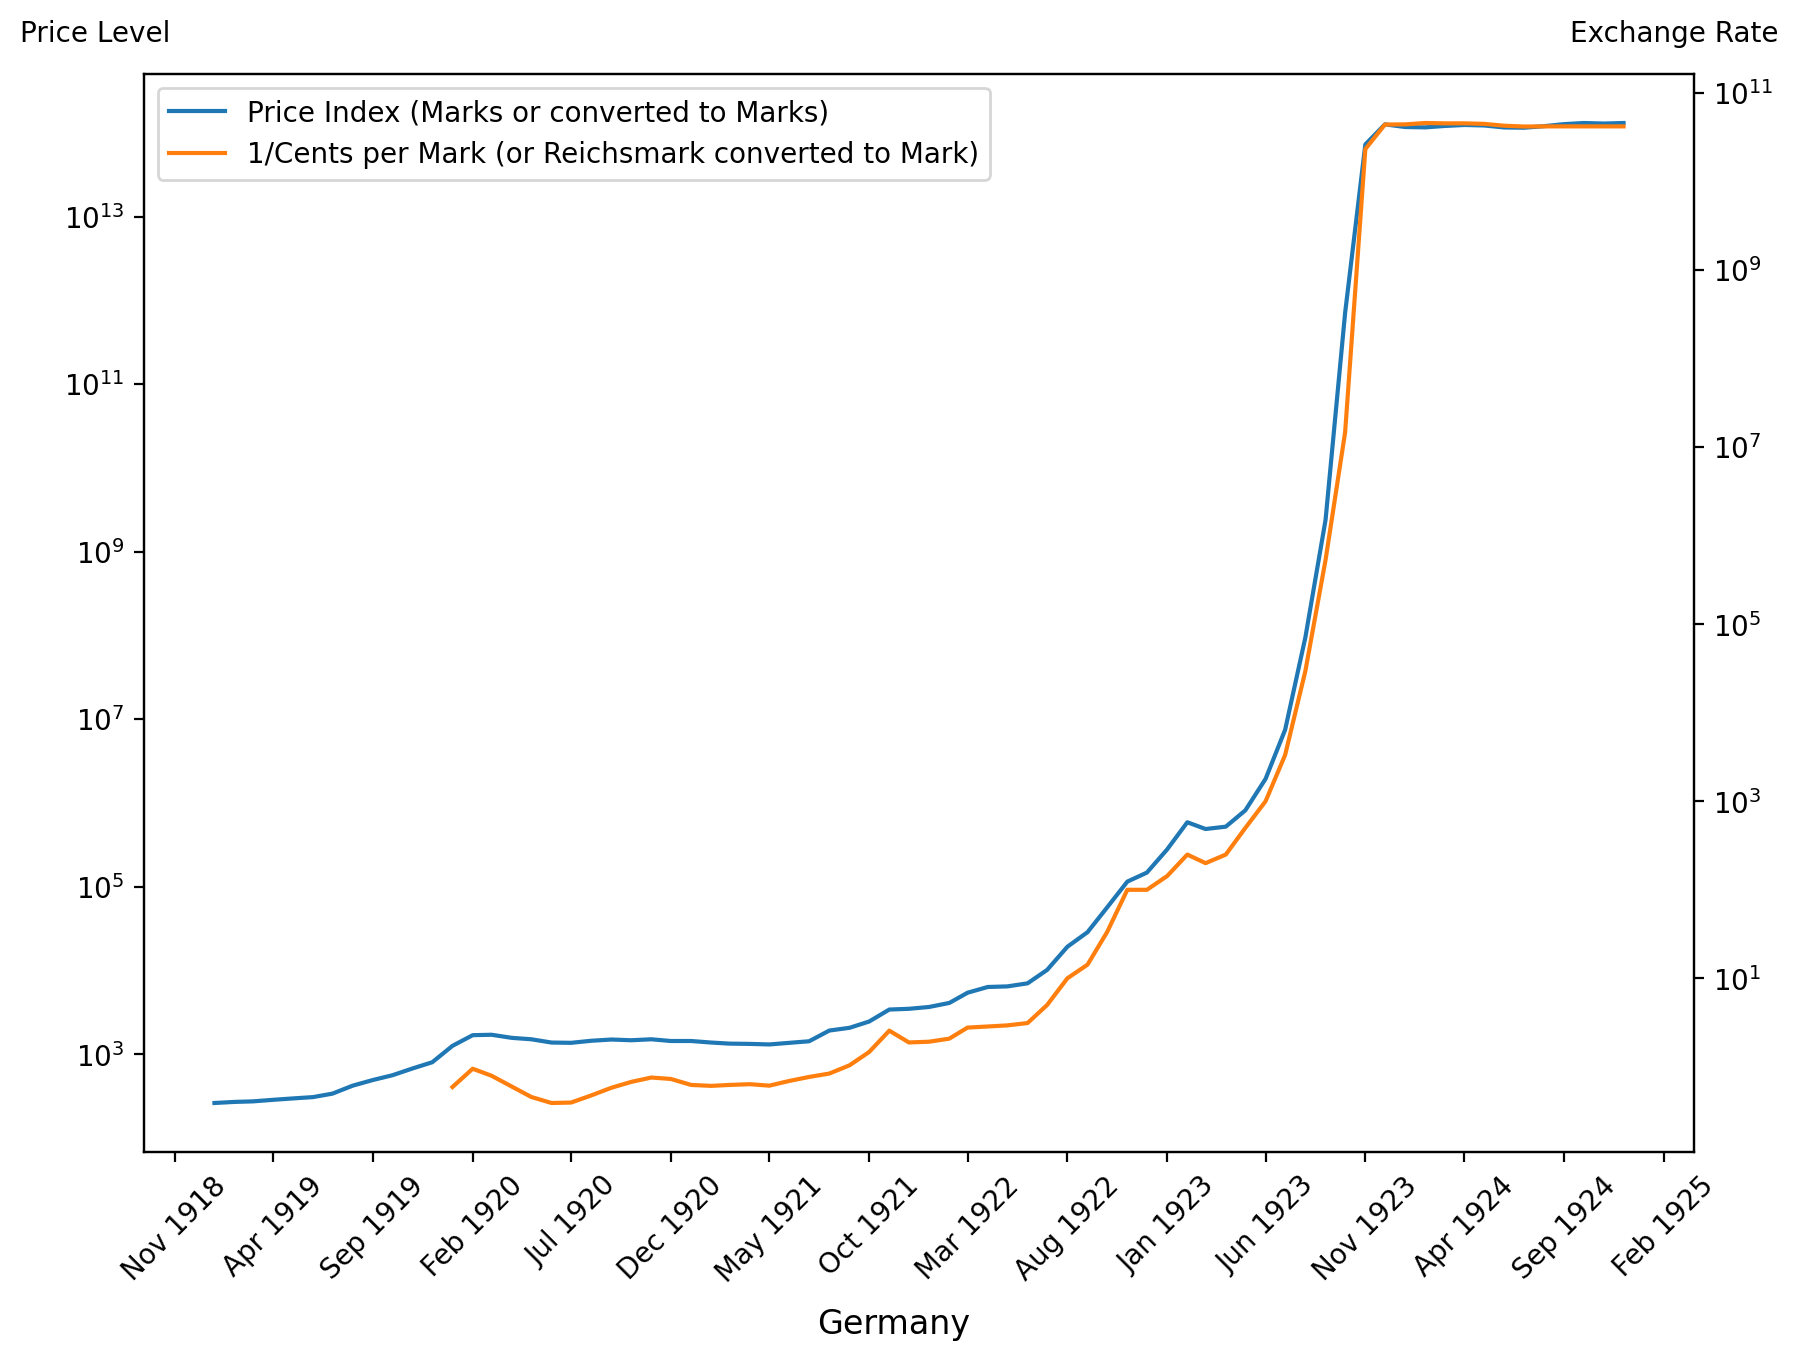

In [17]:
p_seq = df_Germ['Price index (on basis of marks before July 1924,  reichsmarks after)'].copy()
e_seq = 1/df_Germ['Cents per mark'].copy()

# adjust the price level/exchange rate after the currency reform
p_seq[p_seq.index > '06-01-1924'] = p_seq[p_seq.index > '06-01-1924'] * 1e12
e_seq[e_seq.index > '12-01-1923'] = e_seq[e_seq.index > '12-01-1923'] * 1e12

lab = ['Price Index (Marks or converted to Marks)', '1/Cents per Mark (or Reichsmark converted to Mark)']

# create plot
fig, ax = plt.subplots(figsize=[10,7], dpi=200)
ax1 = create_plot(p_seq, e_seq, df_Germ.index, lab, ax)

plt.figtext(0.5, -0.02, 'Germany', horizontalalignment='center', fontsize=12)
plt.show()